# Demo

In [1]:
# Basic libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="deep")
from PIL import Image

In [2]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embedding import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder

/root/miniconda3/envs/biosgen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/BiOSGen/osgen/vae.py:158: SyntaxWarning: invalid escape sequence '\m'
  KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}


## Load data

In [3]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


### Extract patches

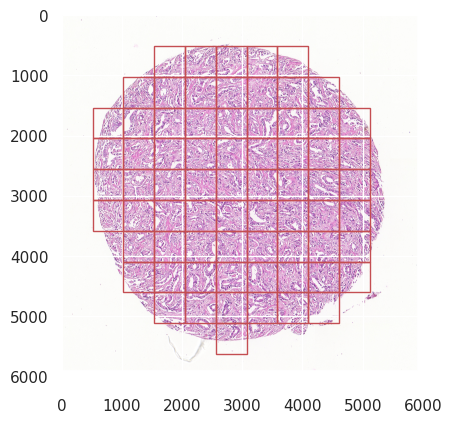

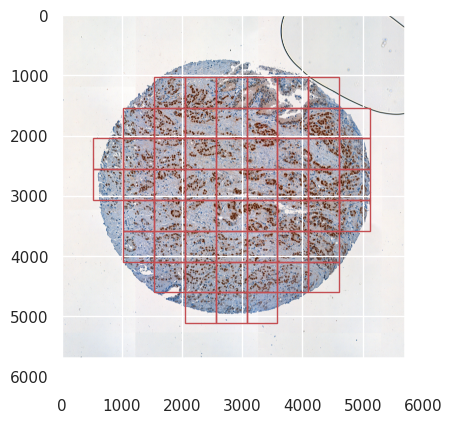

In [4]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

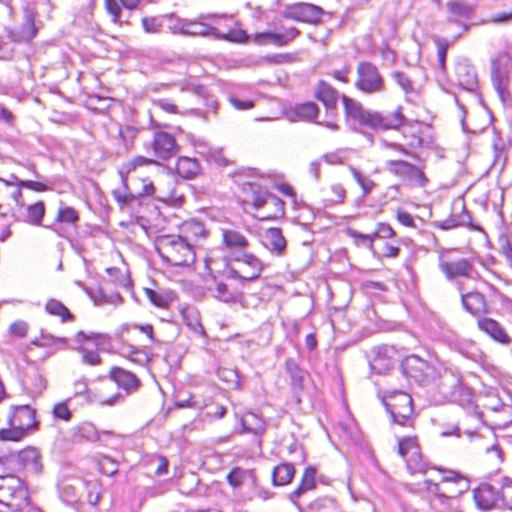

In [5]:
# Get patch to test
test_patch_src = patches_src[10]
Image.fromarray(test_patch_src)

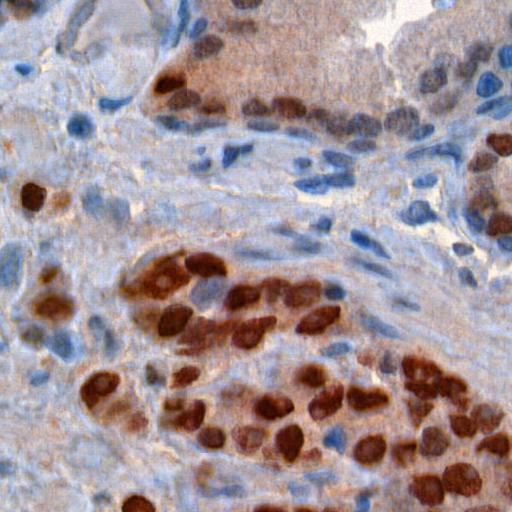

In [6]:
# Get patch to test
test_patch_dst = patches_dst[10]
Image.fromarray(test_patch_dst)

## Style extractor test

In [7]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [8]:
extractor = StyleExtractor()
out = extractor(test_patch_dst_tensor)
print("out shape: ", out.shape)

/root/miniconda3/envs/biosgen/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/biosgen/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


out shape:  torch.Size([1, 18, 512])


## Full VAE test

In [45]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 128, 128])
Latent log_var shape: torch.Size([1, 64, 128, 128])


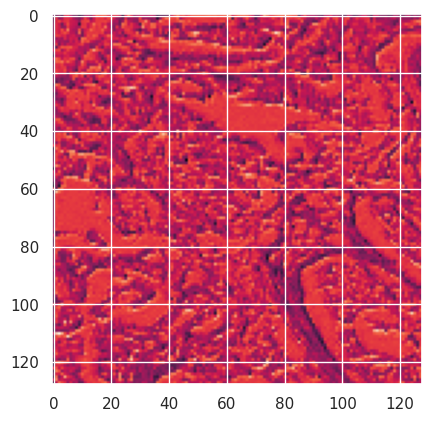

In [46]:
plt.imshow(log_var[0][0].cpu().numpy())

## Encoder test

In [ ]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=256,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128, 256, 512]
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    encoded = encoder(test_patch_src_tensor)

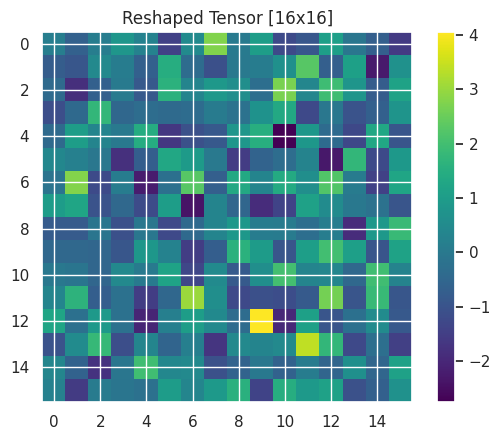

In [ ]:
# Example tensor
x = encoded[0].cpu().numpy()  # Convert to numpy for visualization

# Reshape to 16x16
x_reshaped = x.reshape(16, 16)

# Visualize
plt.imshow(x_reshaped, cmap='viridis')
plt.colorbar()
plt.title("Reshaped Tensor [16x16]")
plt.show()


## U-Net model